"Bank Marketing" dataset classification project
----

Welcome everyone visiting my GitHub! <br>
This project's purpose was to build a predictive model which would detect customers interested in opening term deposit with high accuracy. Following ML algorithms: Decision Tree, Random Forest and XGBoost were used to achieve that goal. All of them except the last one are part of a scikit-learn library.

The "Bank Marketing" dataset is from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing).
It refers to an unknown bank in Portugal.

As a main model quality metric, I chose Sensitivity, although I also took a look at Accuracy and Specificity. Apart from this, I made ROC Curve plots along with AUC values for both training and test sets for each model.

The dataset contains 20 features and a binary target variable. To increase models' performance, I created 8 additional features. All of the original variables are described on the dataset website, URL is provided above.

From a business point of view, I assumed that False Negative cases would generate the biggest loss for the Bank. That is why I wrote a function which looks for optimal threshold which maximizes Sensitivity for each classifier. I based on information from [this](https://mateuszgrzyb.pl/wybor-punktu-odciecia-uwarunkowania-biznesowe-praktyka/) article (only in Polish) when performing this.

As usual, I'm starting with importing necessary libraries and loading the data into working memory:

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import matplotlib.style as style
style.use('ggplot')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import *
import pickle

In [3]:
df = pd.read_csv(os.path.join('data','bank-additional','bank-additional-full.csv'), sep=';', header=0)

Next I'm checking the size of our dataset and variable types. I also take a look at 10 randomly chosen observations.

In [4]:
df.shape

(41188, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
27832,30,student,single,high.school,no,no,no,cellular,mar,fri,...,5,10,2,failure,-1.8,92.843,-50.0,1.640,5099.1,yes
27179,50,blue-collar,married,basic.9y,no,yes,yes,cellular,nov,fri,...,7,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,no
37352,57,admin.,married,university.degree,no,yes,no,cellular,aug,tue,...,1,999,1,failure,-2.9,92.201,-31.4,0.883,5076.2,yes
26415,38,technician,married,university.degree,no,no,no,cellular,nov,thu,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,no
35533,37,blue-collar,married,professional.course,no,yes,no,cellular,may,mon,...,1,999,1,failure,-1.8,92.893,-46.2,1.244,5099.1,no
13254,34,admin.,single,university.degree,no,yes,no,cellular,jul,wed,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
23680,39,technician,divorced,professional.course,no,yes,no,cellular,aug,thu,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,no
20279,38,admin.,married,university.degree,unknown,no,no,cellular,aug,mon,...,5,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
40430,30,self-employed,single,university.degree,no,unknown,unknown,cellular,aug,mon,...,2,999,0,nonexistent,-1.7,94.027,-38.3,0.904,4991.6,no
29887,54,management,married,university.degree,unknown,no,no,cellular,apr,mon,...,3,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no


So the dataset contains 41 188 observations described with 21 features and a target variable.
There are no missing values, which was also mentioned by the author of the dataset. Let's remove __'DURATION'__ variable due to author's suggestion:

In [7]:
df.drop('duration', axis=1, inplace=True)

E.D.A.
----

In the next few steps, I will perform a basic __exploratory data analysis__, starting with examining variables' distributions.

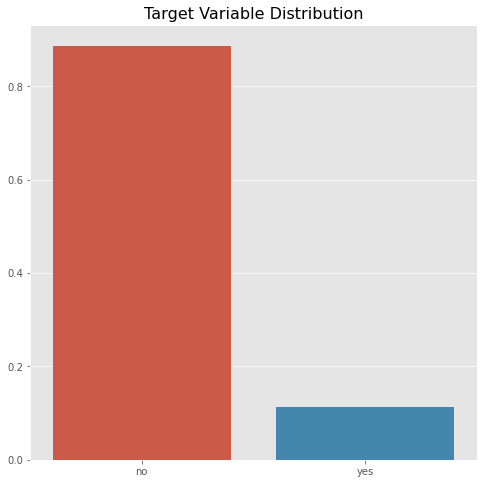

In [8]:
plt.figure(figsize=(8, 8))
y_dist = df['y'].value_counts(normalize=True)
sns.barplot(x=y_dist.index, y=y_dist.values).set_title('Target Variable Distribution', fontsize=16)
plt.show()

Only around 11% of all bank customers represent positive class, so the dataset is definitely unbalanced. That is why I chose Sensitivity as a main metric - Accuracy alone may lead to mistaken conclusions.

Now let's inspect distributions of categorical and discrete features:

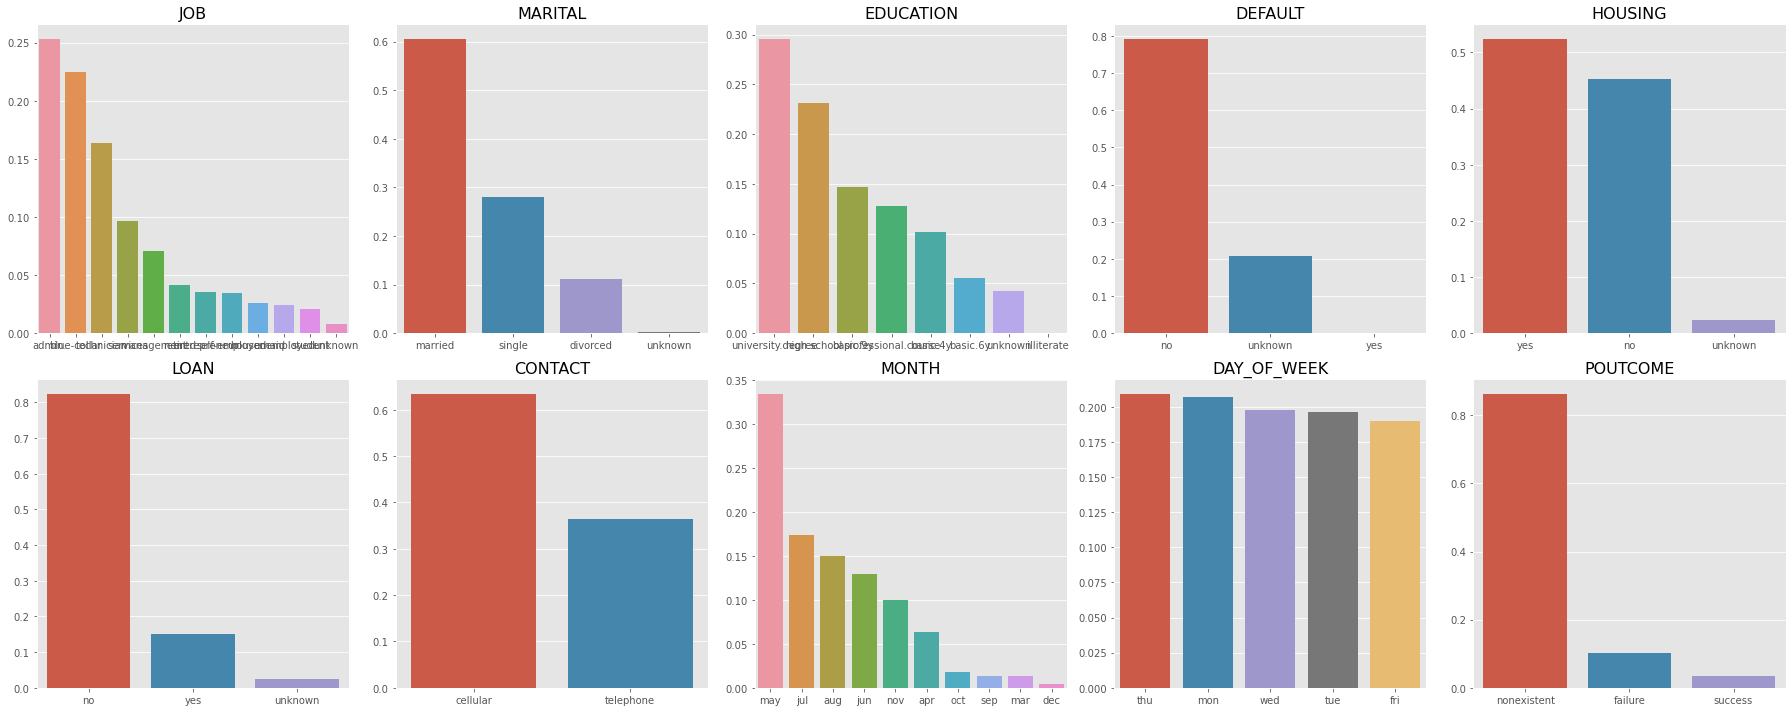

In [9]:
cat_vars_to_plot = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
value_counts_list = []
for var in cat_vars_to_plot:
    value_counts_list.append(df[var].value_counts(normalize=True))
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
value_counts_list = np.array(value_counts_list, dtype='object')
value_counts_list = value_counts_list.reshape(2, 5)
for i in range(value_counts_list.shape[0]):
    for j in range(value_counts_list.shape[1]):
        sns.barplot(x=value_counts_list[i, j].index, y=value_counts_list[i, j].values, ax=axes[i,j]).set_title(value_counts_list[i, j].name.upper(), fontsize=16)
plt.tight_layout()
plt.show()

All variables except 'DAY_OF_WEEK' have unbalanced distributions.

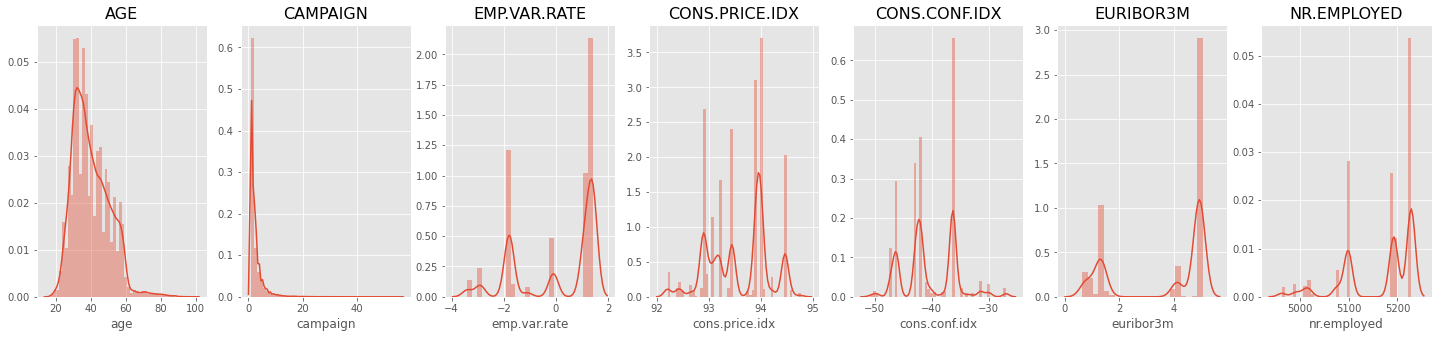

In [11]:
num_features = ['age', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
fig, axes = plt.subplots(1, 7, figsize=(25,5))
for i, feature in enumerate(num_features):
    sns.distplot(df[feature], ax=axes[i]).set_title(feature.upper(), fontsize=16)
plt.show()

From all continous variables, only 'AGE' seems to have distribution similar to Gaussian. This information will be important when performing correlation analysis.

'JOB' and 'EDUCATION' plots were quite not readable, so let's take a look at value_counts() for each of them:

In [12]:
df['job'].value_counts(normalize=True)

admin.           0.253035
blue-collar      0.224677
technician       0.163713
services         0.096363
management       0.070992
retired          0.041760
entrepreneur     0.035350
self-employed    0.034500
housemaid        0.025736
unemployed       0.024619
student          0.021244
unknown          0.008012
Name: job, dtype: float64

In [13]:
df['education'].value_counts(normalize=True)

university.degree      0.295426
high.school            0.231014
basic.9y               0.146766
professional.course    0.127294
basic.4y               0.101389
basic.6y               0.055647
unknown                0.042027
illiterate             0.000437
Name: education, dtype: float64

In 'JOB', admins and blue-collars are the most numerous groups. When inspecting 'EDUCATION', we can see that most of the customers have a university degree or a high school diploma.

In the next few steps I performed several actions:

- created 8 new features:
    - __'life_stability'__: categorical, describing each customer's life stability basing on his Job and Marital status;
    - __'curr_camp_contact_freq'__: categorical, describing frequency of contacts with each customer in current marketing campaighn;
    - __'prev_camp_contact'__: binary, 1 if there was a contact with a customer in a previous marketing campaighn and 0 if there was not;
    - __'prev_camp_contact_freq'__: categorical, describing frequency of contacts with each customer in previous marketing campaighn;
    - __'empvarrate_per_employee'__: continous, 'emp.var.rate' divided by 'nr.employed';
    - __'consumerprice_per_consumerconfidence'__; continous, 'cons.price.idx'' divided by 'cons.conf.idx';
    - __'empvarrate_per_consumerprice'__: continous, 'emp.var.rate' divided by 'cons.price.idx';
    - __'consumerprice_per_employed'__: continous, 'cons.price.idx' divided by 'nr.employed'.
- performed __one-hot encoding__ due to the fact that XGBoost accepts only numerical features, and it is easier to compute a correlation matrix with such features;
- inspected __correlation__ between Y and each X feature in order to see if creating features mentioned above was a good idea; I also inspected mutual correlation between X-es;
- __split__ the dataset into __separate training and test sets__ with 75%:25% proportion and making sure "Y" distribution will be the same in both sets;
- performed __feature scaling__ with help of a __"MinMaxScaler()"__ class from sklearn to bring features onto the same scale - I fitted an appropriate object to the training set and transformed both training and test sets with it so they could be comparable to each other.

In [14]:
def life_stability(data):
    if data['job'] in ['admin', 'technician', 'management', 'enterpreneur', 'self_employed'] and data['marital'] == 'married':
        return 4
    elif data['job'] in ['admin', 'technician', 'management', 'enterpreneur', 'self_employed'] and data['marital'] != 'married':
        return 3
    elif (data['job'] in ['admin', 'technician', 'management', 'enterpreneur', 'self_employed']) == False and data['marital'] == 'married':
        return 2
    elif (data['job'] in ['admin', 'technician', 'management', 'enterpreneur', 'self_employed']) == False and data['marital'] != 'married':
        return 1

df['life_stability'] = df.apply(life_stability, axis=1)

In [15]:
df.life_stability.value_counts()

2    19169
1    12352
4     5759
3     3908
Name: life_stability, dtype: int64

In [16]:
df['campaign'].value_counts()

1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
15       51
16       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
25        8
26        8
28        8
30        7
31        7
35        5
33        4
32        4
34        3
40        2
42        2
43        2
37        1
39        1
41        1
56        1
Name: campaign, dtype: int64

In [17]:
def curr_camp_contact_freq(data):
    if data['campaign'] <= 56 and data['campaign'] >= 27:
        return 5
    elif data['campaign'] >= 21:
        return 4
    elif data['campaign'] >= 15:
        return 3
    elif data['campaign'] >= 10:
        return 2
    else:
        return 1

df['curr_camp_contact_freq'] = df.apply(curr_camp_contact_freq, axis=1)

In [18]:
df['curr_camp_contact_freq'].value_counts()

1    40094
2      688
3      249
4       88
5       69
Name: curr_camp_contact_freq, dtype: int64

In [19]:
df['pdays'].value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

In [20]:
def prev_camp_contact(data):
    if data['pdays'] == 999:
        return 0
    else:
        return 1

df['prev_camp_contact'] = df.apply(prev_camp_contact, axis=1)

In [21]:
df['previous'].value_counts(sort=True)

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

In [22]:
def prev_camp_contact_freq(data):
    if data['previous'] == 0:
        return 0
    elif data['previous'] <= 3:
        return 1
    else:
        return 2

df['prev_camp_contact_freq'] = df.apply(prev_camp_contact_freq, axis=1)

In [23]:
df['empvarrate_per_employee'] = df['emp.var.rate'] / df['nr.employed']
df['consumerprice_per_consumerconfidence'] = df['cons.price.idx'] / df['cons.conf.idx']
df['empvarrate_per_consumerprice'] = df['emp.var.rate'] / df['cons.price.idx']
df['consumerprice_per_employed'] = df['cons.price.idx'] / df['nr.employed']

In [24]:
columns_to_encode = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
df = pd.concat([df, pd.get_dummies(df[columns_to_encode])], axis=1)
df['y'] = df['y'].map(dict(yes=1, no=0))
df.drop(columns_to_encode, axis=1, inplace=True)

I chose __Spearman rank coefficient__ as a correlation metric for several reasons:
- Pearson coefficient inspects only linear correlation;
- Pearson assumes that inspected features come from normal distribution;
- Spearman should perform better with our "Y", which is binary. 

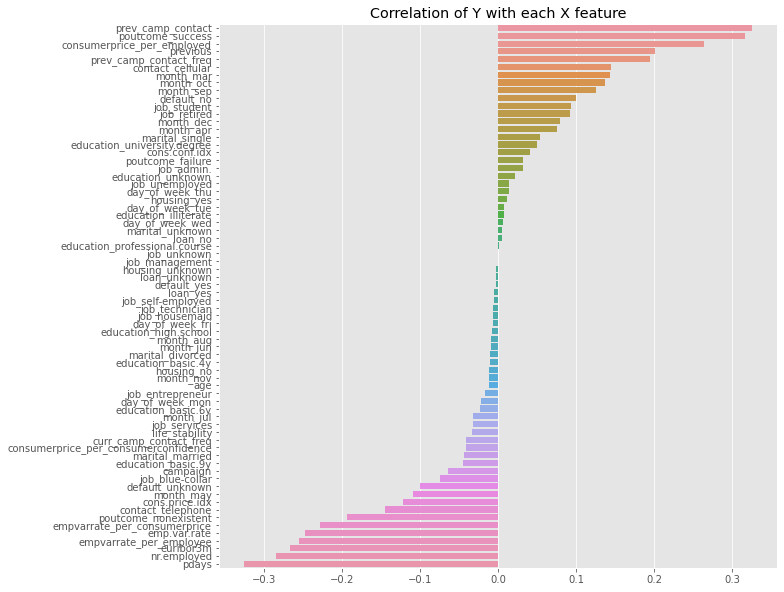

In [25]:
corr_matrix = df.corr(method='spearman')
y_corr = corr_matrix['y'].drop('y').sort_values(ascending=False)
plt.figure(figsize=(10, 10))
sns.barplot(x=y_corr.values, y=y_corr.index).set_title('Correlation of Y with each X feature')
plt.show()

We can see that creating additional features was a good idea - __"prev_camp_contact"__, __"consumerprice_per_employed"__, __"prev_camp_contact_freq"__, __"empvarrate_per_employee"__ and __"empvarrate_per_consumerprice"__ are doing well. An absolute value from a correlation coefficient between 0.2 and 0.3 can be considered as acceptable.

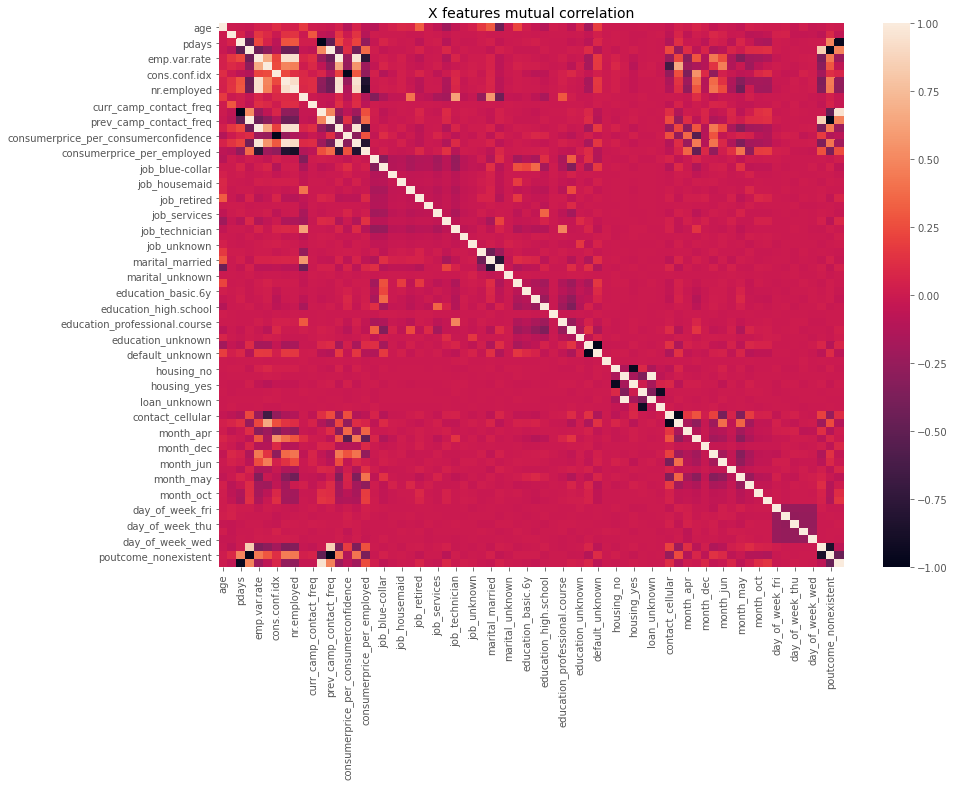

In [26]:
X_corr = corr_matrix.drop('y', axis=0)
X_corr.drop('y', axis=1, inplace=True)
plt.figure(figsize=(14, 10))
sns.heatmap(X_corr).set_title('X features mutual correlation', fontsize=14)
plt.show()

X mutual correlation is quite predictable - in most cases it is low, it is high mainly when inspecting different variants of the same feature.

Now I will split the dataset into separate training and test sets and keep 'Y' separate from X matrix.

In [27]:
y = df['y'].copy()
X = df.drop('y', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
print('X_train size:', X_train.shape)
print('X_test size:', X_test.shape)
print('y_train size:', y_train.shape)
print('y_test size:', y_test.shape)

X_train size: (30891, 70)
X_test size: (10297, 70)
y_train size: (30891,)
y_test size: (10297,)


After performing all of the steps above, there is 70 features in the X matrix. Now i will bring them onto the same scale with the __MinMaxScaler()__ class:

In [28]:
skaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(skaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(skaler.transform(X_test), columns=X_test.columns)

Training machine learning models
------------------------------------------------

Before training ML models, I will define functions mentioned at the beginning of this notebook.

The first one __finds optimal threshold__ for each trained classifier:

In [3]:
def find_optimal_threshold(model, X=X_train_scaled, y=y_train):
    
    probs = model.predict_proba(X)[:,1]
    thresholds = np.arange(0.01, 1.01, 0.01)
    results = {}
    for threshold in thresholds:
        tn, fp, fn, tp = confusion_matrix(y, probs>threshold).ravel()
        cost = tn * -15 + fn * 75
        results[threshold] = cost
    results = pd.Series(results)
    results = results[results == results.min()]
    optimum = round(results.index[0], 2)
    return optimum

The second one __makes prediction with specified threshold__:

In [4]:
def predict_with_threshold(model, x=X_test_scaled, threshold=0.5):
    
    probs = model.predict_proba(x)[:,1]
    classes = np.where(probs >= threshold, 1, 0)
    return classes

The third one __evaluates trained model__ with classification metrics mentioned before:

In [5]:
def evaluate(model, X_train=X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test, prob=0.5):
    
    sensitivity_train = round(recall_score(y_train, predict_with_threshold(model, X_train, threshold=prob)), 2)
    sensitivity_test = round(recall_score(y_test, predict_with_threshold(model, X_test, threshold=prob)), 2)
    accuracy_train = round(accuracy_score(y_train, predict_with_threshold(model, X_train, threshold=prob)), 2)
    accuracy_test = round(accuracy_score(y_test, predict_with_threshold(model, X_test, threshold=prob)), 2)
    specificity_train = round(recall_score(y_train, predict_with_threshold(model, X_train, threshold=prob), pos_label=0), 2)
    specificity_test = round(recall_score(y_test, predict_with_threshold(model, X_test, threshold=prob), pos_label=0), 2)

    return {'Training set: ':{'accuracy: ':accuracy_train, 'sensitivity: ': sensitivity_train, 'specificity: ': specificity_train},
            'Test set: ':{'accuracy: ':accuracy_test, 'sensitivity: ': sensitivity_test, 'specificity: ': specificity_test}
            }

The fourth and last one __plots the ROC curve__ for a classifier for both training and test sets:

In [6]:
def plot_ROC(model, X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, y_test=y_test, title='ROC'):
    
    probs_train = model.predict_proba(X_train)
    preds_train = probs_train[:,1]
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, preds_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    probs_test = model.predict_proba(X_test)
    preds_test = probs_test[:,1]
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, preds_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.plot(fpr_train, tpr_train, 'b', label = 'AUC train = %0.2f' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, 'g', label = 'AUC test = %0.2f' % roc_auc_test)
    plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black')
    plt.legend(loc = 'lower right', prop={'size': 14})
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Now let's get to the main and most entertaining part - training ML models!
In order to find the optimal hyperparameters for each algorithm faster, I imported __GridSearchCV()__ class from scikit-learn so I could perform grid search.

Let's start with a Decision tree algorithm:

In [7]:
tree = DecisionTreeClassifier()
paramgrid = [{
    'criterion':['gini', 'entropy'],
    'splitter':['best', 'random'],
    'max_depth':range(1, 70)
}]
tree_grid = GridSearchCV(tree, param_grid=paramgrid, scoring='recall', return_train_score=True, n_jobs=-1,)
tree_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': range(1, 70),
                          'splitter': ['best', 'random']}],
             return_train_score=True, scoring='recall')

In [8]:
tree_grid.best_estimator_

DecisionTreeClassifier(max_depth=40, splitter='random')



Now let's fit a tree with hyperparameters as above and evaluate it with a default 0.5 threshold:


In [9]:
tree = DecisionTreeClassifier(max_depth=40, splitter='random')
tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=40, splitter='random')

In [10]:
print(evaluate(tree))

{'Training set: ': {'accuracy: ': 1.0, 'sensitivity: ': 1.0, 'specificity: ': 1.0}, 'Test set: ': {'accuracy: ': 0.84, 'sensitivity: ': 0.37, 'specificity: ': 0.9}}


We can see that our tree is strongly overfitted, which does not have to be a suprise accually - the Decision Tree algorithm is highly prone to overfitting. Let's plot a ROC curve:

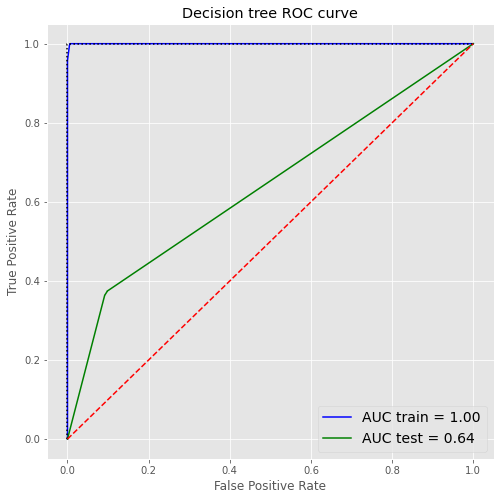

In [11]:
plot_ROC(model=tree, title='Decision tree ROC curve')

As we can clearly see, this tree is really strongly overfitted. Let's limit its max depth to 10 (pruning the tree is one of the best ways to prevent overfitting):

In [12]:
tree = DecisionTreeClassifier(max_depth=10, splitter='random')
tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=10, splitter='random')

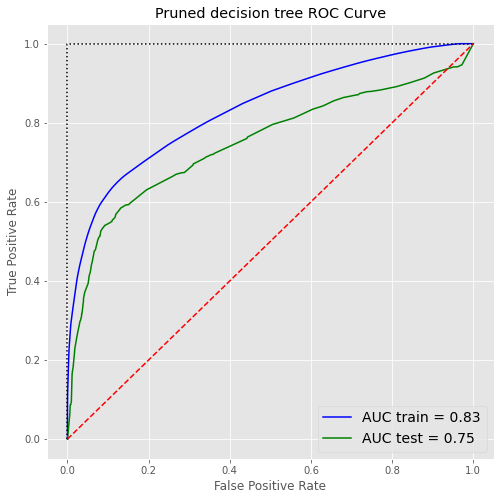

In [13]:
plot_ROC(model=tree, title='Pruned decision tree ROC Curve')

Much better now! However, it still seems to be overfitted - a 0.08 difference in AUC between train and test sets is too big to be accepted.
However, let's see how a __"find_optimal_threshold()__ function works:

In [14]:
find_optimal_threshold(tree)

0.16

So we see that 0.16 is the threshold which maximizes our tree's sensitivity. Let's use the __"evaluate()"__ function with the tree and computed threshold:

In [15]:
print(evaluate(tree, prob=0.16))

{'Training set: ': {'accuracy: ': 0.88, 'sensitivity: ': 0.6, 'specificity: ': 0.92}, 'Test set: ': {'accuracy: ': 0.87, 'sensitivity: ': 0.54, 'specificity: ': 0.91}}


Let's save the __"tree"__ object to an external file with __"pickle"__ library:

In [41]:
filename_tree = 'decisiontree.sav'
pickle.dump(tree, open(filename_tree, 'wb'))

Maybe it's not that bad, but the degree of overfitting is just too big.

The next algorithm I will use is __Random Forest__. It is much less prone to overfitting than Decision Tree, so our results should be better. Let's perform previous actions again:

In [42]:
trees_num_range = np.arange(40, 440, 40)
max_depth_range = np.arange(1, 9, 1)
parameters = {'criterion':['gini', 'entropy'],
'n_estimators':trees_num_range,
'max_depth':max_depth_range
}
random_forest = RandomForestClassifier()
random_forest_grid = GridSearchCV(random_forest, param_grid=parameters, scoring='recall', n_jobs=-1)
random_forest_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8]),
                         'n_estimators': array([ 40,  80, 120, 160, 200, 240, 280, 320, 360, 400])},
             scoring='recall')

In [43]:
random_forest_grid.best_estimator_

RandomForestClassifier(max_depth=8, n_estimators=80)

In [44]:
random_forest = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=80, n_jobs=-1)
random_forest.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=80,
                       n_jobs=-1)

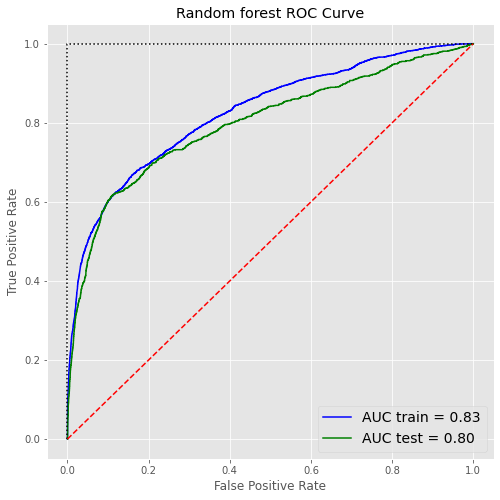

In [16]:
plot_ROC(model=random_forest, title='Random forest ROC Curve')

Well, that looks quite promising! The overfitting degree for random forest is much smaller. Let's run the remaning functions:

In [17]:
opt_threshold_randomforest = find_optimal_threshold(random_forest)
print('Optimal threshold for Random Forest: {}'.format(str(opt_threshold_randomforest)))
print('\n')
print(evaluate(model=random_forest, prob=opt_threshold_randomforest))

Optimal threshold for Random Forest: 0.18


{'Training set: ': {'accuracy: ': 0.87, 'sensitivity: ': 0.6, 'specificity: ': 0.9}, 'Test set: ': {'accuracy: ': 0.87, 'sensitivity: ': 0.6, 'specificity: ': 0.9}}


The results can be satisfying! Sensitivity is equal to 60% for both sets, both remaining metrics are also high - accually all the metrics are the same for both sets!

In [18]:
filename_forest = 'randomForest.sav'
pickle.dump(random_forest, open(filename_forest, 'wb'))

Now let's train the last remaining classifier - __XGBoost__. The computational complexity of this algorithm is very high, so I will set a "verbose" hyperparameter to a positive number in order to see the GridSearch() output.

In [48]:
boosted = xgb.XGBClassifier()
param_grid = [{
        'learning_rate':np.arange(0.01, 0.11, 0.01),
        'max_depth':np.arange(2, 11, 1),
        'n_estimators':np.arange(10, 65, 5),
        'gamma':np.arange(0.01, 0.11, 0.01),
        'reg_lambda':np.arange(0.1, 0.6, 0.1)
}]
grid_search_xgb = GridSearchCV(boosted, param_grid=parameters, scoring='recall', n_jobs=-1, verbose=10)
grid_search_xgb.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:  2

[18:10:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [49]:
grid_search_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='gini', gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
boosted = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='gini', gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=400, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
boosted.fit(X_train_scaled, y_train)

[18:12:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='gini', gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

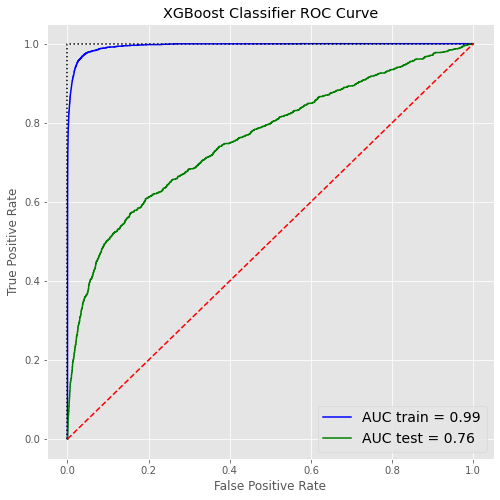

In [51]:
plot_ROC(model=boosted, title='XGBoost Classifier ROC Curve')

As we can see, the XGBoost classifier is highly overfitted. Let's experiment with some hyperparameters, especially for regulatization, but not only:

In [54]:
boosted = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='gini', gamma=0.55,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=290, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=1, reg_lambda=0.5, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
boosted.fit(X_train_scaled, y_train)

[18:16:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='gini',
              gamma=0.55, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=290, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=1, reg_lambda=0.5,
              scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

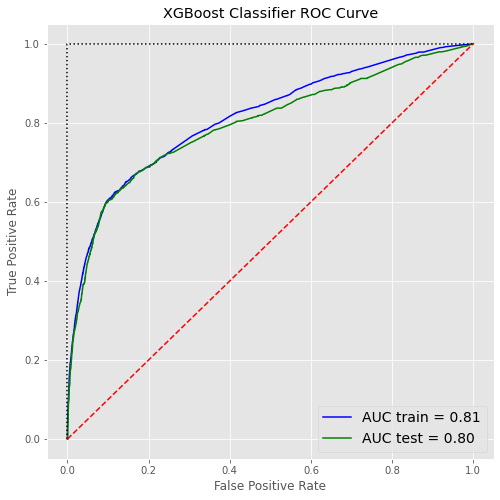

In [19]:
plot_ROC(model=boosted, title='XGBoost Classifier ROC Curve')

This looks much better! Let's find optimal threshold and evaluate the model:<br>

In [20]:
opt_threshold_xgb = find_optimal_threshold(boosted)
print('Optimal threshold for XGBoost: {}'.format(str(opt_threshold_xgb)))
print('\n')
print(evaluate(model=boosted, prob=opt_threshold_xgb))

Optimal threshold for XGBoost: 0.2


{'Training set: ': {'accuracy: ': 0.87, 'sensitivity: ': 0.6, 'specificity: ': 0.9}, 'Test set: ': {'accuracy: ': 0.87, 'sensitivity: ': 0.6, 'specificity: ': 0.9}}


As we can see, the classification metrics are exactly the same like in the random forest's case! 

In [57]:
filename_xgb = 'xgboost.sav'
pickle.dump(boosted, open(filename_xgb, 'wb'))

Conclusions
----

Let's remind the purpose of this project, which was to build a classifier for detecting customers interested in opening deposits, and __sensitivity__ was the main model quality metric. <br> Considering that, both Random Forest and XGboost were considered as the best with the following metrics values for both training and test sets: <br>
- Accuracy: 87%
- Sensitivity: 60%
- Specificity: 90%
<br> <br>
Both models are good and stable. However, I chose the XGB model as a little bit better because it had a little smaller overfitting degree.

That's it! If you have any questions, comments or you think I should have done something in a different way, feel free to contact me. These are my e-mail addresses: [kossakowskim19@gmail.com](kossakowskim19@gmail.com), [kossakowskim@outlook.com](kossakowskim@outlook.com).